# Distance-based treatment effects (plot for different stroke types)

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

Here we show the difference in outcome measures for nLVO, LVO, and a mixed population (65% nLVO, 35% LVO). There is 60 min travel time between IVT and MT centres.

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

# Assumptions 

Fixed times for additional delays:

In [3]:
# All fixed times have units of minutes
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment = 30,
    transfer_additional_delay = 60,
    travel_ivt_to_mt = 50,
    mt_arrival_to_treatment = 90,
    )

Define a helper function to build the time grid:

In [4]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [5]:
def make_grids_travel_time(time_travel_ivt_to_mt, time_travel_max, ivt_coords, mt_coords, grid_step=1):        
    # Make the grid a bit larger than the max travel time: 
    grid_xy_max = time_travel_max + grid_step*2

    grid_time_travel_directly_to_ivt = make_time_grid(
        grid_xy_max, grid_step, x_offset=ivt_coords[0], 
        y_offset=ivt_coords[1])

    grid_time_travel_directly_to_mt = make_time_grid(
        grid_xy_max, grid_step, x_offset=mt_coords[0], y_offset=mt_coords[1])

    grid_time_travel_directly_diff = (
        grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

    extent = [-grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5, 
              -grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5] 
    
    return (grid_time_travel_directly_to_ivt, 
        grid_time_travel_directly_to_mt,
        grid_time_travel_directly_diff, 
        extent)

---

## Plot travel times

### Grids

In [6]:
from outcome_utilities.geography_plot import find_mask_within_flattened_circle

Update plotting style:

In [7]:
time_step_circle = 5
circ_linewidth = 0.5

In [8]:
from outcome_utilities.geography_plot import circle_plot

In [9]:
def make_grids_treatment_time(
    grid_time_travel_directly_to_ivt,
    grid_time_travel_directly_to_mt,
    times_dir):
    """
    Define new treatment time grids. 
    """
    grid_time_ivt_at_ivtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_ivt + 
        times_dir['ivt_arrival_to_treatment']
        )

    grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_ivt + 
        times_dir['ivt_arrival_to_treatment'] + 
        times_dir['transfer_additional_delay'] + 
        times_dir['travel_ivt_to_mt'] + 
        times_dir['mt_arrival_to_treatment']
        )

    grid_time_ivt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_mt + 
        times_dir['ivt_arrival_to_treatment']
        )

    grid_time_ivt_then_mt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_mt + 
        times_dir['ivt_arrival_to_treatment'] + 
        times_dir['mt_arrival_to_treatment']
        )
    return (grid_time_ivt_at_ivtcentre,
            grid_time_ivt_at_ivt_then_mt_at_mtcentre,
            grid_time_ivt_at_mtcentre,
            grid_time_ivt_then_mt_at_mtcentre)

In [10]:
from outcome_utilities.clinical_outcome import Clinical_outcome

mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists)

In [11]:
def find_grid_outcomes(outcome_model, grid_time_ivt, grid_time_mt, 
                       patient_props):
    """
    For all pairs of treatment times, calculate the changes in utility
    and mRS for the patient population. 
    
    Inputs:
    
    Returns:
    
    """
    grid_shape = grid_time_ivt.shape
    utility_grid = np.empty(grid_shape)
    mRS_grid = np.empty(grid_shape)
    good_outcomes_grid = np.empty(grid_shape)

    for row in range(grid_shape[0]):
        for col in range(int(grid_shape[1]*0.5)+1):
            # ^ weird range is for symmetry later when filling grids.
            # Expect col_opp, the opposite column as reflected in the 
            # x=0 axis, to contain the same values as col:
            col_opp = grid_shape[1]-1-col
            
            time_to_ivt = grid_time_ivt[row, col]
            time_to_mt = grid_time_mt[row, col]
            outcomes = outcome_model.calculate_outcomes(
                time_to_ivt, time_to_mt, patients=1000)

            # Find the change in utility:
            added_utility = find_weighted_change(
                outcomes['lvo_ivt_added_utility'],
                outcomes['lvo_mt_added_utility'],
                outcomes['nlvo_ivt_added_utility'],
                patient_props
                )
            # Add this value to the grid:
            utility_grid[row,col] = added_utility
            utility_grid[row,col_opp] = added_utility

            # Find the change in mRS:
            reduced_mRS = find_weighted_change(
                outcomes['lvo_ivt_mean_shift'], 
                outcomes['lvo_mt_mean_shift'],
                outcomes['nlvo_ivt_mean_shift'], 
                patient_props
                )
            # Add this value to the grid:
            mRS_grid[row,col] = reduced_mRS
            mRS_grid[row,col_opp] = reduced_mRS

            # Find change in proportion with mRS <=2
            nlvo_ivt_added_good_outcomes = (
                outcomes['nlvo_ivt_cum_probs'][2] - 
                outcomes['nlvo_untreated_cum_probs'][2])
            lvo_ivt_added_good_outcomes = (
                outcomes['lvo_ivt_cum_probs'][2] -
                outcomes['lvo_untreated_cum_probs'][2])
            lvo_mt_added_good_outcomes = (
                outcomes['lvo_mt_cum_probs'][2] -
                outcomes['lvo_untreated_cum_probs'][2])
            added_good_outcomes = find_weighted_change(
                lvo_ivt_added_good_outcomes,
                lvo_mt_added_good_outcomes,
                nlvo_ivt_added_good_outcomes,
                patient_props
                )
            good_outcomes_grid[row,col] = added_good_outcomes
            good_outcomes_grid[row,col_opp] = added_good_outcomes
          
            
    # Adjust outcome for just treated population
    utility_grid = utility_grid / patient_props['treated_population']
    mRS_grid = mRS_grid / patient_props['treated_population']
    return utility_grid, mRS_grid, good_outcomes_grid

In [12]:
def find_weighted_change(change_lvo_ivt, change_lvo_mt, change_nlvo_ivt, 
                         patient_props):
    """
    Take the total changes for each category and calculate their
    weighted sum, where weights are from the proportions of the 
    patient population.
    
    (originally from matrix notebook)
    
    Inputs:
    
    Returns:
    
    """
    # If LVO-IVT is greater change than LVO-MT then adjust MT for 
    # proportion of patients receiving IVT:
    if change_lvo_ivt > change_lvo_mt:
        diff = change_lvo_ivt - change_lvo_mt
        change_lvo_mt += diff * patient_props['lvo_mt_also_receiving_ivt']

    # Calculate changes multiplied by proportions (cp):
    cp_lvo_mt = (
        change_lvo_mt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_mt']
        )
    cp_lvo_ivt = (
        change_lvo_ivt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_only']
        )
    cp_nlvo_ivt = (
        change_nlvo_ivt * 
        patient_props['nlvo'] * 
        patient_props['nlvo_treated_ivt_only']
        )
        
    total_change = cp_lvo_mt + cp_lvo_ivt + cp_nlvo_ivt
    return total_change

# Combined circle plot

Share these colour limits between all figures:

In [13]:
vmin_time = 0 
vmax_time = 60
vmin_util = -0.025 # -0.045
vmax_util = 0.08 # 0.035
vmin_mRS = -0.1 # -0.250 
vmax_mRS = 0.15 # 0.175
vmin_good = -0.005
vmax_good = 0.025

Make new colour maps that are based on a diverging colour map but have the zero (white) off-centre:

In [14]:
from outcome_utilities.geography_plot import make_new_cmap_diverging

cmap_util = make_new_cmap_diverging(
    vmin_util, vmax_util, cmap_base='bwr_r', cmap_name='bwr_util')
cmap_mRS = make_new_cmap_diverging(
    vmin_mRS, vmax_mRS, cmap_base='bwr', cmap_name='bwr_mRS')
cmap_good = make_new_cmap_diverging(
    vmin_good, vmax_good, cmap_base='bwr_r', cmap_name='bwr_good')

# For the time colours, take only the red half of 'bwr':
from matplotlib import colors
colours_time = plt.get_cmap('bwr')(np.linspace(0.5, 1.0, 256))
cmap_time = colors.LinearSegmentedColormap.from_list('bwr_time', colours_time)

Define contour levels for plotting: 

In [15]:
from outcome_utilities.geography_plot import make_levels_with_zeroish

level_step_util = 0.01 # 0.005
levels_util = make_levels_with_zeroish(
    level_step_util, vmax_util, zeroish=1e-3, vmin=vmin_util)

level_step_mRS = 0.025 # 0.025
levels_mRS = make_levels_with_zeroish(
    level_step_mRS, vmax_mRS, zeroish=4e-3, vmin=vmin_mRS)

level_step_good_outcome = 0.0025 # 0.025
levels_good_outcome = make_levels_with_zeroish(
    level_step_good_outcome, vmax_good, zeroish=5e-5, vmin=vmin_good)

The following big cell calculates the new grids and then makes the plots.

In [16]:
time_travel_ivt_to_mt  = 60
time_onset_to_ambulance_arrival = 60

patient_props_list = [
    dict(
    lvo = 0,
    nlvo = 1, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    ),
    dict(
    lvo = 1,
    nlvo = 0, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    ),
    dict(
    lvo = 0.35,
    nlvo = 1.0-0.35, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    )
]

#patient_props_list = [patient_props_list[0]]

titles = ['nLVO', 'LVO', '65% nLVO, 35% LVO']

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  60
Utility -0.0239  0.0000
mRS  0.0000  0.1360
Good outcomes -0.0040  0.0000


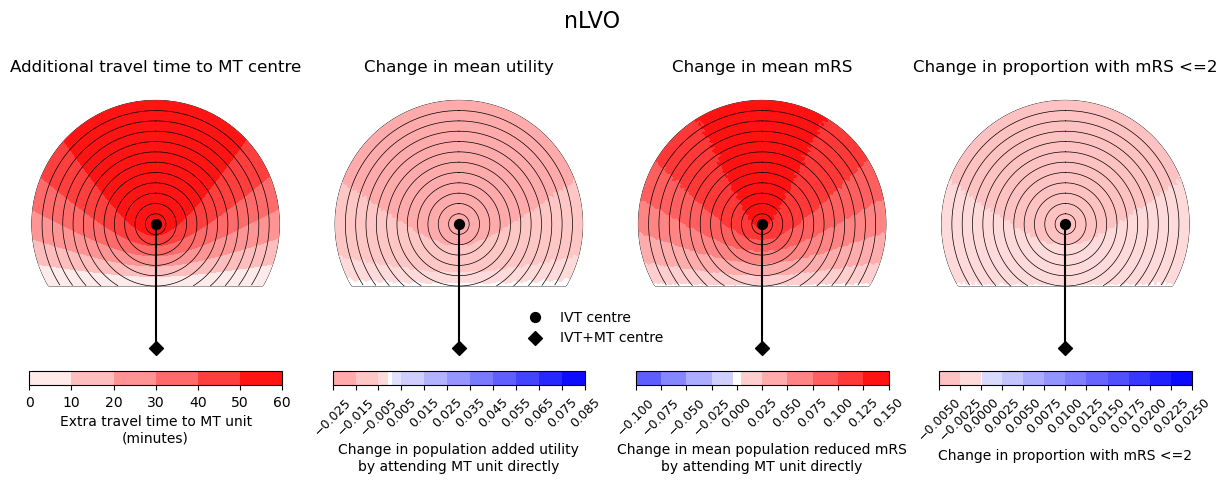

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  60
Utility  0.0345  0.0721
mRS -0.0569  0.0255
Good outcomes  0.0103  0.0217


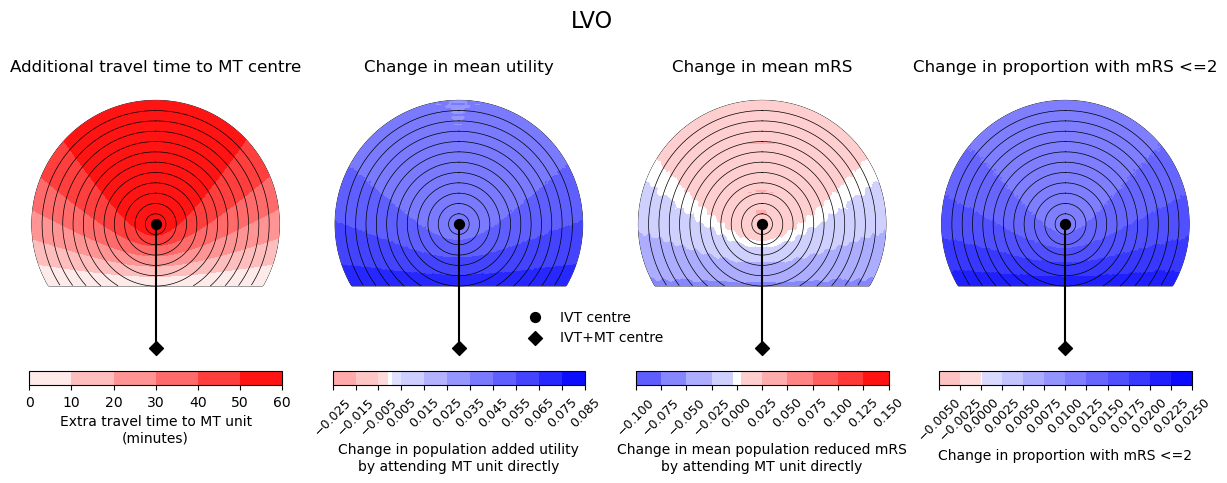

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  60
Utility  0.0054  0.0360
mRS -0.0283  0.0800
Good outcomes  0.0010  0.0076


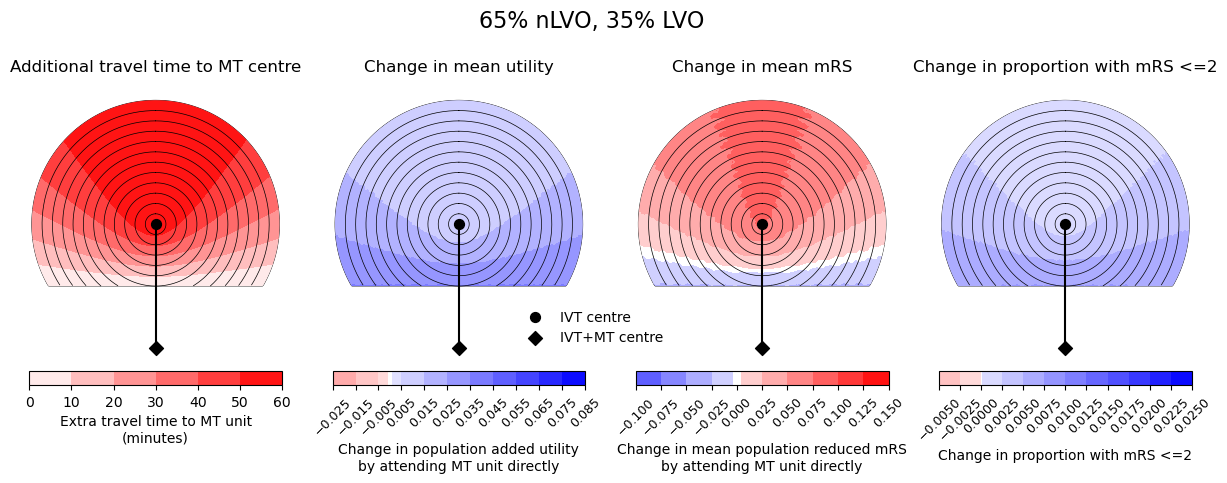

In [17]:
# Recalculate some values: 
ivt_coords = [0, 0]
mt_coords  = [0, -time_travel_ivt_to_mt] 
# Only calculate travel times up to this x or y displacement:
time_travel_max = time_travel_ivt_to_mt 
# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the travel time grids: 
(grid_time_travel_directly_to_ivt, 
grid_time_travel_directly_to_mt,
grid_time_travel_directly_diff, 
extent) = \
make_grids_travel_time(time_travel_ivt_to_mt, time_travel_max, 
                        ivt_coords, mt_coords, grid_step=1)

# Find grid coordinates within the largest circle: 
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max)
coords_valid = np.where(grid_mask<1)

for count, patient_props in enumerate(patient_props_list):

    treated_population = (
    patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_only']
    )

    patient_props['treated_population'] = treated_population

    # Build a new dictionary of fixed times: 
    times_dir = {}
    for key in fixed_times:
        times_dir[key] = fixed_times[key]
    times_dir['onset_to_ambulance_arrival'] = time_onset_to_ambulance_arrival
    times_dir['travel_ivt_to_mt'] = time_travel_ivt_to_mt
    
    # Grids of times to treatment:
    (grid_time_ivt_at_ivtcentre,
    grid_time_ivt_at_ivt_then_mt_at_mtcentre,
    grid_time_ivt_at_mtcentre,
    grid_time_ivt_then_mt_at_mtcentre) = \
    make_grids_treatment_time(grid_time_travel_directly_to_ivt,
        grid_time_travel_directly_to_mt, times_dir)

    # Grids of changed outcomes
    # Case 1: IVT at the IVT centre, then MT at the IVT/MT centre
    grid_utility_case1, grid_mRS_case1, grid_good_outcomes_case1 = find_grid_outcomes(
        outcome_model,
        grid_time_ivt_at_ivtcentre, 
        grid_time_ivt_at_ivt_then_mt_at_mtcentre, 
        patient_props
        )
    # Case 2: IVT at the IVT/MT centre, then MT at IVT/MT centre
    grid_utility_case2, grid_mRS_case2, grid_good_outcomes_case2 = find_grid_outcomes(
        outcome_model,
        grid_time_ivt_at_mtcentre, 
        grid_time_ivt_then_mt_at_mtcentre, 
        patient_props
        )
    # Difference between them:
    grid_utility_diff = grid_utility_case2 - grid_utility_case1
    grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1
    grid_good_outcomes_diff = grid_good_outcomes_case2 - grid_good_outcomes_case1
    

    print('-'*50)
    print(f'Time of travel from IVT to MT: {time_travel_ivt_to_mt:2d}')
    print(f'Time from onset to ambulance arrival: ',
            f'{time_onset_to_ambulance_arrival:2d}')
    
    print(f'Utility {np.min(grid_utility_diff[coords_valid]):7.4f} '+
            f'{np.max(grid_utility_diff[coords_valid]):7.4f}')
    print(f'mRS {np.min(grid_mRS_diff[coords_valid]):7.4f} '+
            f'{np.max(grid_mRS_diff[coords_valid]):7.4f}')
    print(f'Good outcomes {np.min(grid_good_outcomes_diff[coords_valid]):7.4f} '+
            f'{np.max(grid_good_outcomes_diff[coords_valid]):7.4f}')

        # Plot setup:  
    fig, axs = plt.subplots(2, 4, figsize=(15,4), 
    gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]})
    ax_time = axs[0,0]
    ax_time_cbar = axs[1,0]
    ax_util = axs[0,1]
    ax_util_cbar = axs[1,1]
    ax_mRS = axs[0,2]
    ax_mRS_cbar = axs[1,2]
    ax_good = axs[0,3]
    ax_good_cbar = axs[1,3]

    # Travel time:
    circle_plot(
        -grid_time_travel_directly_diff, 
        time_travel_ivt_to_mt, 
        time_travel_max, 
        time_step_circle, 
        vmin_time, 
        vmax_time, 
        ivt_coords=ivt_coords, 
        mt_coords=mt_coords,             
        extent=extent,
        imshow=0, 
        ax=ax_time, 
        cax=ax_time_cbar, 
        cmap=cmap_time,
        cbar_label='Extra travel time to MT unit\n(minutes)', 
        cbar_orientation='horizontal',
        n_contour_steps=6)

    ax_time.set_title('Additional travel time to MT centre')

    # Draw legend now:
    fig.legend(loc='upper center', bbox_to_anchor=[0.5,0.33], ncol=1, frameon=False)


    # Good outcomes
    circle_plot(
        grid_good_outcomes_diff,
        time_travel_ivt_to_mt,
        time_travel_max,
        time_step_circle,
        vmin_good,
        vmax_good,
        ivt_coords=ivt_coords,
        mt_coords=mt_coords,
        extent=extent,
        imshow=0,
        ax=ax_good,
        cax=ax_good_cbar,
        cmap=cmap_good,
        cbar_label='Change in proportion with mRS <=2',
        cbar_orientation='horizontal',
        # cbar_format_str='{:3.2f}', 
        levels=levels_good_outcome, 
        cbar_ticks=np.arange(
            vmin_good, vmax_good+level_step_good_outcome, level_step_good_outcome))
    ax_good.set_title('Change in proportion with mRS <=2')

    # mRS:
    circle_plot(
        grid_mRS_diff, 
        time_travel_ivt_to_mt, 
        time_travel_max, 
        time_step_circle, 
        vmin_mRS, 
        vmax_mRS, 
        ivt_coords=ivt_coords, 
        mt_coords=mt_coords,
        extent=extent,
        imshow=0, 
        ax=ax_mRS, 
        cax=ax_mRS_cbar, 
        cmap=cmap_mRS, 
        cbar_label='Change in mean population reduced mRS\n'+
                    'by attending MT unit directly',
        cbar_orientation='horizontal',
        # cbar_format_str='{:3.2f}', 
        levels=levels_mRS, 
        cbar_ticks=np.arange(
            vmin_mRS, vmax_mRS+level_step_mRS, level_step_mRS))

    ax_mRS.set_title('Change in mean mRS')
    
    # Utility:
    circle_plot(
        grid_utility_diff, 
        time_travel_ivt_to_mt, 
        time_travel_max, 
        time_step_circle, 
        vmin_util, 
        vmax_util, 
        ivt_coords=ivt_coords, 
        mt_coords=mt_coords,
        extent=extent,
        imshow=0, 
        ax=ax_util, 
        cax=ax_util_cbar, 
        cmap=cmap_util, 
        cbar_label=('Change in population added utility\n'+
                    'by attending MT unit directly'),
        cbar_orientation='horizontal',
        levels=levels_util,
        # cbar_format_str='{:3.3f}',
        cbar_ticks=np.arange(
            vmin_util, vmax_util+level_step_util, level_step_util))

    ax_util.set_title('Change in mean utility')

    for ax in [ax_time, ax_util, ax_mRS, ax_good]:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_color('None')
        ax.set_ylim(-70,70)
        # Reduce font size of ax.xaxis.label
        ax.tick_params(axis='both', which='major', labelsize=9)

    # Rotate colourbar tick labels to prevent overlapping:
    for ax in [ax_mRS_cbar, ax_util_cbar, ax_good_cbar]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(9)
            tick.set_horizontalalignment('center')


    # Set supertitle 
    fig.suptitle(titles[count], fontsize=16, y=1.05)

    filename = (f'circle_plots_stroke_type_{titles[count]}_60_60')
    plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
    plt.show()